In [1]:
import os
import cv2 as cv
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from typing import List, Union 
import math
from math import sin, cos, fabs, ceil, floor
from collections import defaultdict
import time

# def retrieve_name(var):
#     import inspect
#     callers_local_vars = inspect.currentframe().f_back.f_locals.items()
#     return [var_name for var_name, var_val in callers_local_vars if var_val is var][0]
        
def show_bgr(imgs: Union[cv.Mat, List[cv.Mat]], labels: Union[str, List[str]] = None, is_show = False):
    if not is_show:
        return
    
    if type(imgs) == list and len(imgs) == 1:
        imgs = imgs[0]
    if type(imgs) == list:
        num = len(imgs)
        fig, axs = plt.subplots(1, num)
        fig.set_figwidth(17 * len(imgs))
        for i in range(num):
            if labels and len(labels) == num:
                axs[i].set_title(labels[i])
            axs[i].imshow(cv.cvtColor(imgs[i], cv.COLOR_BGR2RGB))
    else:
        plt.figure()
        if labels:
            plt.title(labels)
        plt.imshow(cv.cvtColor(imgs, cv.COLOR_BGR2RGB))
    plt.show()

def resize_img(img: cv.Mat, size: tuple) -> cv.Mat:
    h, w, _ = img.shape
    assert len(size) == 2
    new_w, new_h = size
    if w < new_w and h < new_h:
        return img.copy()
    w, h = w * new_h / h, h * new_w / w
    w = int(min(w, new_w))
    h = int(min(h, new_h))
    return cv.resize(img, (w, h))

def adjust_contrast(img: cv.Mat) -> cv.Mat:
    pass

def cvt_bin_img(img: cv.Mat) -> cv.Mat:
    img_blurred = cv.GaussianBlur(img, (3, 3), 0)
    # img_blurred = cv.medianBlur(img, 5)
    # img_blurred = cv.pyrMeanShiftFiltering(img, 10, 100)
    # img_gray = cv.cvtColor(img_blurred, cv.COLOR_BGR2GRAY)
    # img_bin = cv.adaptiveThreshold(img_gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
    # img_bin = np.invert(img_bin)
    ret, img_bin = cv.threshold(img_blurred, 100, 255, cv.THRESH_BINARY_INV)
    if img_bin.ndim == 3:
        img_bin = img_bin[:, :, 0]
    return img_bin

# def detector_hough_line_mask(img: cv.Mat) -> cv.Mat:
#     img_mask = np.zeros_like(img)
#     img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
#     img_edge = cv.Canny(img_gray, 20, 50, apertureSize=3)
#     lines = cv.HoughLinesP(img_edge, rho=1., theta=np.pi/170, threshold=100, minLineLength=10, maxLineGap=100)
#     for i in range(len(lines)):
#         cv.line(img_mask, (lines[i, 0, 0], lines[i, 0, 1]), (lines[i, 0, 2], lines[i, 0, 3]), (255, 255, 255), 2)
#     return img_mask

def erode(img_mask: cv.Mat, iterations=1) -> cv.Mat:
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3)) # fill: MORPH_RECT, |: MORPH_CROSS, +: MORPH_ELLIPSE
    eroded = cv.erode(img_mask, kernel, iterations=iterations)
    # dilated = cv.dilate(img_mask, kernel, iterations=iterations)
    return eroded

def dilate(img_mask: cv.Mat, iterations=1) -> cv.Mat:
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
    dilated = cv.dilate(img_mask, kernel, iterations=iterations)
    return dilated

def cvt_edge(img: cv.Mat) -> cv.Mat:
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_edges = cv.Canny(img_gray, 20, 100, apertureSize=3)
    return img_edges

def detector_lsd_gray(img_gray: cv.Mat) -> cv.Mat:
    # lsd = cv.createLineSegmentDetector(ang_th=22.5)
    lsd = cv.createLineSegmentDetector(0)
    # lines, width, prec, nfa = lsd.detect(img_gray)
    lines = lsd.detect(img_gray)[0]   # Position 0 of the returned tuple are the detected lines
    if lines is None:
        return img.copy(), None
    img_zeros = np.zeros_like(img_gray)
    # print(lines)
    img_out = lsd.drawSegments(img_zeros, lines)
    # img_out = cv.cvtColor(img_out, cv.COLOR_BGR2GRAY)
    return img_out, lines

def detector_lsd(img: cv.Mat) -> cv.Mat:
    img_gray, lines = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return detector_lsd_gray(img)

def cvtPot(img_bin: cv.Mat) -> np.ndarray:
    pots = []
    for y in range(img_bin.shape[0]):
        for x in range(img_bin.shape[1]):
            if img_bin[y][x] != 0:
                pots.append([x, y]) # x,y
    return np.array(pots)

def cvt_color_hex2rgb(hex: str, type="rgb") -> list:
    assert len(hex) == 7
    r = int(hex[1:3], base=16)
    g = int(hex[3:5], base=16)
    b = int(hex[5:7], base=16)
    if type == "rgb":
        return [r, g, b]
    elif type == "bgr":
        return [b, g, r]

def cvtImg(img: cv.Mat, pots: np.ndarray, labels: list, colors = None) -> cv.Mat:
    if colors is None:
        colors = [
            "#ff006e", "#2a9d8f", "#3a86ff", "#ffbe0b",
            "#f4a261", "#a3b18a", "#a2d2ff", "#faedcd",
        ]
    img = img.copy()
    h, w, c = img.shape
    for idx in range(len(pots)):
        x, y = pots[idx]
        img[y, x] = cvt_color_hex2rgb(colors[labels[idx]], type="bgr")
    return img

def detect_hough_line_gray(img_blurred: cv.Mat, is_show = False) -> (bool, list, cv.Mat):
    '''
    Return:
        bool: is exist line
        List[List[int, int, int, int]]: lines
        cv.Mat: mask
    '''
    h, w = img_blurred.shape[0], img_blurred.shape[1]
    min_line_length = int(min(h, w) * 0.5)
    max_line_gap = 50
    img_mask = np.zeros_like(img)
    
    img_edge = cv.Canny(img_blurred, 20, 50, apertureSize=3)
    lines = cv.HoughLinesP(img_edge, rho=1., theta=np.pi/170, threshold=100, minLineLength=min_line_length, maxLineGap=max_line_gap) # minLineLength: 10, maxLineGap: 100
    if lines is None:
        return False, None, None
    for i in range(len(lines)):
        cv.line(img_mask, (lines[i, 0, 0], lines[i, 0, 1]), (lines[i, 0, 2], lines[i, 0, 3]), (255, 255, 255), 2)
    show_bgr([img_blurred, img_edge, img_mask], ["blurred", "edge", "mask_line"], is_show = is_show)
    return True, lines, img_mask

def detect_hough_line(img: cv.Mat) -> (bool, list, cv.Mat):
    '''
    Return:
        bool: is exist line
        List[List[int, int, int, int]]: lines
        cv.Mat: mask
    '''
    # min_line_length = int(min(img.shape) * 0.1) # 10%
    # max_line_gap = min_line_length * 10
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_blurred = cv.GaussianBlur(img_gray, (5, 5), 10, 10)
    # img_blurred = cv.medianBlur(img, 5)
    return detect_hough_line_gray(img_blurred)

def check_line_length(lines: np.ndarray, threshold = 100) -> bool:
    for i in range(len(lines)):
        a = np.array([lines[i, 0, 0], lines[i, 0, 1]])
        b = np.array([lines[i, 0, 2], lines[i, 0, 3]])
        return True if cal_point_distance(a, b) > threshold else False

def clear_lines(img: cv.Mat, img_mask: cv.Mat, is_show = False) -> cv.Mat:
    # mask1
    img_mask1 = dilate(img_mask, 3)

    # mask2
    # img_edge = cvt_edge(img)
    img_mask2 = img

    # img_mask2 = cv.bitwise_not(img_mask2)
    # img_mask2 = dilate(img_mask2, 1)
    if img_mask2.ndim == 2:
        img_mask2 = np.expand_dims(img_mask2, 2).repeat(3, axis=2)

    # img_mask3 = img_mask2 - img_mask1   # will be negative value. (other: cv.bitwise_or(src1, src2))
    img_mask3 = cv.subtract(img_mask2, img_mask1)
    
    # img_mask4 = img_mask2 - img_mask3
    img_mask4 = cv.subtract(img_mask2, img_mask3)
    
    show_bgr([img_mask1, img_mask2, img_mask3, img_mask4], ["mask1", "mask2", "mask3", "mask4"], is_show = is_show)
    return img_mask3

def cluster_img(img_bin: cv.Mat, n_clusters=2) -> (List[List[int]], List[int]):
    """
    Parameters:
        img_bin:    cv.Mat, shape = [h, w]
        n_clusters: int, num cluster

    Return:
        List[int]:  label
    """
    pots = cvtPot(img_bin)
    if pots.size == 0:
        return [], []
    clustering = KMeans(n_clusters=n_clusters).fit(pots)
    return pots, clustering.labels_

def clear_dirty(img: cv.Mat, rate_area = 0.0002, threshold_area = None) -> cv.Mat:
    if threshold_area is None:
        threshold_area = img.shape[0] * img.shape[1] * rate_area
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(img, connectivity=8, ltype=None)
    img = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    for i in range(1, num_labels):
        mask = labels == i             # 通过labels确定区域位置，让labels信息赋给mask数组，再用mask数组做img数组的索引
        if stats[i][4] > threshold_area:
            img[mask] = 255
        else:
            img[mask] = 0
    return img

def clear_dirty2(img: cv.Mat, rate_area = 0.0002, threshold_area = None) -> cv.Mat:
    img = img.copy()
    if threshold_area is None:
        threshold_area = img.shape[0] * img.shape[1] * rate_area
    contours, hierarch = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    area = 0.
    for i in range(len(contours)):
        area = cv.contourArea(contours[i])
        if area < threshold_area:
            cv.drawContours(img, [contours[i]], 0, 0, -1)
            continue
    return img

def fit_min_rect(img: cv.Mat) -> (np.ndarray, cv.Mat, list):
    img = img.copy()
    contours, hierarch = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    # cnt = contours[0] # only index 0
    if len(contours) <= 0:
        return None, img, []
    cnt = np.concatenate(contours, axis=0)
    rect = cv.minAreaRect(cnt)
    box = cv.boxPoints(rect)
    box = np.intp(box)
    cv.drawContours(img, [box], 0, (255, 0, 255), 2)
    return box, img, contours

def find_rect(img: cv.Mat) -> cv.Mat:
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_blurred = cv.GaussianBlur(img_gray, (5, 5), 10, 10)
    # img_blurred = cv.medianBlur(img, 5)
    # img_edge = cv.Canny(img_blurred, 20, 50, apertureSize=3)
    img_edge = cv.Canny(img_blurred, 20, 100, apertureSize=3)
    img_dilate = dilate(img_edge, 1)
    # show_bgr(img_dilate, "edge")

    contours, _ = cv.findContours(img_dilate, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    # find max area
    max_area = 0.
    max_contour = None
    for contour in contours:
        cur_area = cv.contourArea(contour)
        if cur_area > max_area:
            max_area = cur_area
            max_contour = contour
    return max_contour, max_area

def get_rect_box(contour):
    hull = cv.convexHull(contour)
    epsilon = 0.02 * cv.arcLength(contour, True)
    approx = cv.approxPolyDP(hull, epsilon, True) # convex more than the 4 when epsilon is 0
    approx = approx.reshape((len(approx), 2))
    return approx

def rectify_img(img: cv.Mat, box: np.ndarray) -> cv.Mat:
    img = img.copy()
    box = order_points(box)
    if box is None:
        return img, img

    # show
    tmp_img = img.copy()
    cv.drawContours(tmp_img, [box.astype(np.int32)], 0, 127)
    # show_bgr(tmp_img, "box")
    
    img_warped = warp_image(img, box)
    return img_warped, tmp_img

def rotate_retain_total(img: cv.Mat, angle: float) -> cv.Mat:
    h, w = img.shape[0], img.shape[1]
    center = np.array([w / 2, h / 2])
    bound_w = h * fabs(sin(angle * np.pi / 180)) + w * fabs(cos(angle * np.pi / 180))
    bound_h = h * fabs(cos(angle * np.pi / 180)) + w * fabs(sin(angle * np.pi / 180))
    mat_rotation = cv.getRotationMatrix2D(center, angle, 1)
    mat_rotation[0, 2] += (bound_w - w) / 2
    mat_rotation[1, 2] += (bound_h - h) / 2
    img_rotated = cv.warpAffine(img, mat_rotation, np.array([int(bound_w), int(bound_h)]), borderValue=[255, 255, 255])
    return img_rotated

def count_continuous_value(img_bin, value=255, order="H") -> dict:
    count_dict = defaultdict(int)
    h, w = img_bin.shape[0], img_bin.shape[1]
    if order == "V":
        w, h = img_bin.shape[0], img_bin.shape[1]
    for y in range(h):
        count = 0
        for x in range(w):
            if order == "H" and img_bin[y][x] == value:
                count += 1
            elif order == "V" and img_bin[x][y] == value:
                count += 1
            else:
                if count != 0:
                    count_dict[count] += 1
                count = 0
        if count != 0:
            count_dict[count] += 1
    return count_dict

def get_thickness(img_bin: cv.Mat) -> int:
    count_dict_h = count_continuous_value(img_bin)
    count_dict_v = count_continuous_value(img_bin, order="V")
    # merge
    count_dict = defaultdict(int)
    keys = set(count_dict_h.keys())
    keys.update(set(count_dict_v.keys()))
    for k in keys:
        if k in count_dict_h:
            count_dict[k] += count_dict_h[k]
        if k in count_dict_v:
            count_dict[k] += count_dict_v[k]
    if len(count_dict) == 0:
        return 1
    return max(count_dict, key=count_dict.get)

def cal_point_distance(a: np.ndarray, b: np.ndarray) -> int:
    return int(np.sqrt(np.sum(np.square(a - b))))

def order_points(pts: np.ndarray) -> np.ndarray:
    '''
    order and convert int to float
    [top-left, top-right, bottom-right, bottom-left]
    '''
    # assert len(pts) >= 4
    if len(pts) < 4:
        return None
    
    s1 = np.argsort(pts, axis=0)
    # left
    l = pts[s1[[0, 1]][:, 0]]
    s2 = np.argsort(l, axis=0)
    tl = l[s2[0, 1]]
    bl = l[s2[1, 1]]
    # right
    r = pts[s1[[2, 3]][:, 0]]
    s3 = np.argsort(r, axis=0)
    tr = r[s3[0, 1]]
    br = r[s3[1, 1]]
    return np.array([tl, tr, br, bl], dtype="float32")

def warp_image(img: cv.Mat, box: np.ndarray) -> cv.Mat:
    w, h = cal_point_distance(box[0], box[1]), cal_point_distance(box[1], box[2])
    dst_rect = np.array([[0, 0],
                         [w - 1, 0],
                         [w - 1, h - 1],
                         [0, h - 1]], dtype='float32')
    M = cv.getPerspectiveTransform(box, dst_rect)
    warped = cv.warpPerspective(img, M, (w, h))
    return warped

def gray_world(img: cv.Mat):
    '''
        ref: https://cloud.tencent.com/developer/article/1552617
    '''
    img = img.copy()
    
    # 计算 RGB 三个通道的平均值
    avg_R = np.mean(img[:, :, 0])
    avg_G = np.mean(img[:, :, 1])
    avg_B = np.mean(img[:, :, 2])

    # 计算 RGB 三个通道的平均值的平均值
    avg = (avg_R + avg_G + avg_B) / 3

    # 计算每个通道的增益系数
    Kr = avg / avg_R
    Kg = avg / avg_G
    Kb = avg / avg_B

    # 对每个通道进行增益
    img[:, :, 0] = img[:, :, 0] * Kr
    img[:, :, 1] = img[:, :, 1] * Kg
    img[:, :, 2] = img[:, :, 2] * Kb

    # 对增益后的像素值进行截断，保证像素值在 0-255 之间
    img[img > 255] = 255
    img = np.round(img).astype(np.uint8)

    return img


def perfect_reflector_white_balance(img):
    '''
        ref: https://cloud.tencent.com/developer/article/1552619
    '''
    img = img.copy()
    
    b, g, r = cv.split(img)

    # 计算 RGB 三通道的灰度最大值
    Bmax, Gmax, Rmax = np.max(b), np.max(g), np.max(r)

    # 计算 RGB 之和的阈值 T
    threshold_value = int(0.01 * (Bmax + Gmax + Rmax))

    # 计算 RGB 之和大于阈值的像素的均值
    avg_b = np.mean(b[b > threshold_value])
    avg_g = np.mean(g[g > threshold_value])
    avg_r = np.mean(r[r > threshold_value])

    # 计算补偿系数
    max_value = 255.0
    kr = max_value / avg_b
    kg = max_value / avg_g
    kb = max_value / avg_r

    # 对每个通道进行增益
    b = np.clip(b * kb, 0, 255).astype(np.uint8)
    g = np.clip(g * kg, 0, 255).astype(np.uint8)
    r = np.clip(r * kr, 0, 255).astype(np.uint8)

    # 合并通道
    balanced_img = cv.merge([b, g, r])

    return balanced_img
    
def adaptContrastEnhancement(scr, winSize, maxCg):
    '''
        ref: https://blog.csdn.net/u013921430/article/details/83865427
    '''
    def getVarianceMean(scr, winSize):
        if scr is None or winSize is None:
            print("The input parameters of getVarianceMean Function error")
            return -1
        
        if winSize % 2 == 0:
            print("The window size should be singular")
            return -1 
        
        copyBorder_map=cv.copyMakeBorder(scr,winSize//2,winSize//2,winSize//2,winSize//2,cv.BORDER_REPLICATE)
        shape=np.shape(scr)
        
        local_mean=np.zeros_like(scr)
        local_std=np.zeros_like(scr)
        
        for i in range(shape[0]):
            for j in range(shape[1]):   
                temp=copyBorder_map[i:i+winSize,j:j+winSize]
                local_mean[i,j],local_std[i,j]=cv.meanStdDev(temp)
                if local_std[i,j]<=0:
                    local_std[i,j]=1e-8
                
        return local_mean,local_std
    
    if scr is None or winSize is None or maxCg is None:
        print("The input parameters of ACE Function error")
        return -1
    
    YUV_img=cv.cvtColor(scr,cv.COLOR_BGR2YUV)    ##转换通道
    Y_Channel = YUV_img[:,:,0]
    shape=np.shape(Y_Channel)
    
    meansGlobal=cv.mean(Y_Channel)[0]
    
    ##这里提供使用boxfilter 计算局部均质和方差的方法
#    localMean_map=cv2.boxFilter(Y_Channel,-1,(winSize,winSize),normalize=True)
#    localVar_map=cv2.boxFilter(np.multiply(Y_Channel,Y_Channel),-1,(winSize,winSize),normalize=True)-np.multiply(localMean_map,localMean_map)
#    greater_Zero=localVar_map>0
#    localVar_map=localVar_map*greater_Zero+1e-8
#    localStd_map = np.sqrt(localVar_map)
    localMean_map, localStd_map=getVarianceMean(Y_Channel,winSize)
    for i in range(shape[0]):
        for j in range(shape[1]):
            cg = 0.2*meansGlobal/ localStd_map[i,j];
            if cg >maxCg:
                cg=maxCg
            elif cg<1:
                cg=1
            temp = Y_Channel[i,j].astype(float)
            temp=max(0,min(localMean_map[i,j]+cg*(temp-localMean_map[i,j]),255))
#            Y_Channel[i,j]=max(0,min(localMean_map[i,j]+cg*(Y_Channel[i,j]-localMean_map[i,j]),255))
            Y_Channel[i,j]=temp
    YUV_img[:,:,0]=Y_Channel
    dst=cv.cvtColor(YUV_img,cv.COLOR_YUV2BGR)
    return dst

def cvt_contrast(img: cv.Mat) -> cv.Mat:
    img = img.copy()
    b, g, r = cv.split(img)
    b_max, g_max, r_max = np.max(b), np.max(g), np.max(r)
    b_min, g_min, r_min = np.min(b), np.min(g), np.min(r)
    
    # b = ((b_max - b_min) * 255 / b).astype(np.uint8)
    # g = ((g_max - g_min) * 255 / g).astype(np.uint8)
    # r = ((r_max - r_min) * 255 / r).astype(np.uint8)
    h, w, c = img.shape
    for y in range(h):
        for x in range(w):
            img[y, x] = np.array([
                # np.clip cost time: 4.2 s
                # np.clip((b[y, x] - b_min) / (b_max - b_min) * 255, 0, 255),
                # np.clip((g[y, x] - g_min) / (g_max - g_min) * 255, 0, 255),
                # np.clip((r[y, x] - r_min) / (r_max - r_min) * 255, 0, 255),
                (b[y, x] - b_min) / (b_max - b_min) * 255,
                (g[y, x] - g_min) / (g_max - g_min) * 255,
                (r[y, x] - r_min) / (r_max - r_min) * 255,
            ])
    return img

def auto_bin_contrast(img_gray: cv.Mat) -> cv.Mat:
    max_val = np.max(img_gray)
    min_val = np.min(img_gray)
    
    img = img_gray.copy()
    h, w = img.shape
    for y in range(h):
        for x in range(w):
            img[y, x] = (img_gray[y, x] - min_val) / (max_val - min_val) * 255
    return img

def count_hist(val_list: list, resolution: int, size_seg: int) -> list:
    counter = [0] * (ceil(resolution / size_seg) + 1)
    for val in val_list:
        idx = floor(val // size_seg)
        counter[idx] += 1
    return counter

def find_nearest_num(num_list: list, target: float, direction: str = 'forward') -> int:
    if direction == 'forward':
        for x in num_list:
            if x >= target:
                return x
    else:
        for x in num_list[::-1]:
            if x <= target:
                return x
    return num_list[-1] if direction == 'forward' else num_list[0]

def get_xy_list_from_lines(lines: np.ndarray) -> tuple:
    x_list = lines[:, 0, [0, 2]].flatten()
    y_list = lines[:, 0, [1, 3]].flatten()
    return x_list, y_list
    
def get_xy_list_from_img(img: cv.Mat) -> tuple:
    x_list = []
    y_list = []
    for x in range(img.shape[1]):
        for y in range(img.shape[0]):
            if img[y, x] != 0:
                x_list.append(x)
                y_list.append(y)
    return x_list, y_list

def count_hist_xy(xy_list: tuple, size_seg: int, img = None, is_show=False, save_path='out.png'):
    # plt.figure()
    x_val_list, y_val_list = xy_list
    
    v1 = count_hist(x_val_list, img.shape[1], size_seg)
    x1 = np.linspace(0, len(v1) * size_seg, len(v1))
    # print(len(x1), len(v1))
    # plt.title(f"num seg: {size_seg}")
    
    v2 = count_hist(y_val_list, img.shape[0], size_seg)
    x2 = np.linspace(0, len(v2) * size_seg, len(v2))
    # print(len(x2), len(v2))

    # plt.figure()
    vv1 = []
    vv2 = []
    [vv1.extend([x1[i]]*v1[i]) for i in range(len(x1))]
    [vv2.extend([x2[i]]*v2[i]) for i in range(len(x2))]

    Q1x = np.percentile(vv1, 25)
    Q2x = np.percentile(vv1, 50)
    Q3x = np.percentile(vv1, 75)
    IQRx = Q3x - Q1x
    top_x = Q3x + 1.5 * IQRx
    bottom_x = Q1x - 1.5 * IQRx
    bottom_x = find_nearest_num([i * size_seg for i, x in enumerate(v1) if x != 0], floor(bottom_x))
    top_x = find_nearest_num([i * size_seg for i, x in enumerate(v1) if x != 0], ceil(top_x), direction="back")
    # top_x = np.percentile(vv1, 87)
    # bottom_x = np.percentile(vv1, 12)
    # print(Q1x, Q2x, Q3x)
    Q1y = np.percentile(vv2, 25)
    Q2y = np.percentile(vv2, 50)
    Q3y = np.percentile(vv2, 75)
    IQRy = Q3y - Q1y
    top_y = Q3y + 1.5 * IQRy
    bottom_y = Q1y - 1.5 * IQRy
    bottom_y = find_nearest_num([i * size_seg for i, x in enumerate(v2) if x != 0], floor(bottom_y))
    top_y = find_nearest_num([i * size_seg for i, x in enumerate(v2) if x != 0], ceil(top_y), direction="back")
    # top_y = np.percentile(vv2, 87)
    # bottom_y = np.percentile(vv2, 12)
    # print(Q1y, Q2y, Q3y)

    # if is_show:
    fig, axs = plt.subplots(2, 2)
    # fig.set_figwidth(17)
    if img is not None:
        axs[0][0].imshow(cv.cvtColor(img, cv.COLOR_BGR2GRAY), cmap="gray")
    axs[1][0].plot(x1, v1, label = f"x")
    axs[0][1].plot(v2, x2, label = f"y")
    axs[1][1].boxplot([vv1, vv2], vert=False, labels=["x", "y"])
    plt.title(f"num_seg: {size_seg}")
    axs[1][0].legend()
    axs[0][1].legend()

    axs[0][0].vlines([bottom_x, top_x], ymin=10, ymax=img.shape[0]-10, colors='r', linestyles = 'dashed', label='x')
    axs[0][0].hlines([bottom_y, top_y], xmin=10, xmax=img.shape[1]-10, colors='b', linestyles = 'dashed', label='y')
    
    axs[1][1].vlines([bottom_x, top_x], ymin=0.2, ymax=0.8, colors='r', linestyles = 'dashed', label='x')
    axs[1][1].vlines([bottom_y, top_y], ymin=1.2, ymax=1.8, colors='b', linestyles = 'dashed', label='y')
    if is_show:
        plt.show()
    else:
        plt.savefig(f"{save_path}-10_1-box.jpg", format="png")
        plt.close()
    return (bottom_x, top_x), (bottom_y, top_y)

def search_rect_from_area(img: cv.Mat, rect: List[int]) -> List[int]:
    h, w = img.shape[0], img.shape[1]
    x1, y1, x2, y2 = rect
    flag_t, flag_b, flag_l, flag_r = False if y1 == 0 else True, False if y2 == h - 1 else True, False if x1 == 0 else True, False if x2 == w - 1 else True
    while (flag_t or flag_b or flag_l or flag_r) and (y1 >= 0 or y2 <= h - 1 or x1 >= 0 or x2 <= w - 1):
        # print(flag_t, flag_b, flag_l, flag_r, x1, y1, x2, y2)
        # True True False False 191 -1 672 540
        if flag_t and y1 >= 0:
            for x in range(x1, x2):
                flag_t = False
                if img[y1, x] == 255:
                    flag_t = True if y1 > 0 else False
                    y1 -= 1
                    break
        if flag_b and y2 <= h - 1:
            for x in range(x1, x2):
                flag_b = False
                if img[y2, x] == 255:
                    flag_b = True if y2 < h - 1 else False
                    y2 += 1
                    break
        if flag_l and x1 >= 0:
            for y in range(y1, y2):
                flag_l = False
                if img[y, x1] == 255:
                    flag_l = True if x1 > 0 else False
                    x1 -= 1
                    break
        if flag_r and x2 <= w - 1:
            for y in range(y1, y2):
                flag_r = False
                if img[y, x2] == 255:
                    flag_r = True if x2 < w - 1 else False
                    x2 += 1
                    break
    return (max(x1, 0), max(y1, 0), min(x2, w - 1), min(y2, h - 1))

def search_min_rect_from_area(img: cv.Mat, rect: List[int]) -> List[int]:
    h, w = img.shape[0], img.shape[1]
    x1, y1, x2, y2 = rect
    flag_t, flag_b, flag_l, flag_r = True, True, True, True
    while (flag_t or flag_b or flag_l or flag_r) and (y1 < y2 and x1 < x2):
        if flag_t and y1 < y2:
            for x in range(x1, x2):
                flag_t = True
                if img[y1, x] == 255:
                    flag_t = False
                    break
            y1 += 1
        if flag_b and y2 > y1:
            for x in range(x1, x2):
                flag_b = True
                if img[y2, x] == 255:
                    flag_b = False
                    break
            y2 -= 1
        if flag_l and x1 < x2:
            for y in range(y1, y2):
                flag_l = True
                if img[y, x1] == 255:
                    flag_l = False
                    break
            x1 += 1
        if flag_r and x2 > x1:
            for y in range(y1, y2):
                flag_r = True
                if img[y, x2] == 255:
                    flag_r = False
                    break
            x2 -= 1
    return (max(x1, 0), max(y1, 0), min(x2, w - 1), min(y2, h - 1))

def cvt_line_to_pot(lines: np.ndarray) -> np.ndarray:
    pots = []
    for line in lines:
        pots.append([int(line[0, 0]), int(line[0, 1])]) # p1
        pots.append([int(line[0, 2]), int(line[0, 3])]) # p2
    return np.array(pots)

def cluster_gauss_img(lines: np.ndarray, n_clusters=2, is_add_ext_pots=True, img_shape=None) -> (List[List[int]], List[int]):
    from sklearn.mixture import GaussianMixture
    """
    Parameters:
        img_bin:    cv.Mat, shape = [h, w]
        n_clusters: int, num cluster

    Return:
        List[int]:  label
    """
    P = cvt_line_to_pot(lines)
    if P.size == 0:
        return [], []
    if is_add_ext_pots and img_shape:
        h, w = img_shape
        P = P.tolist()
        for x in range(0, w, 40):
            P.append([x, 0])
            P.append([x, h-1])
        for y in range(0, h, 40):
            P.append([0, y])
            P.append([w-1, y])
        P = np.array(P)

    if len(P) < n_clusters:
        return P, None
    # clustering = KMeans(n_clusters=n_clusters).fit(pots)
    # dbscan = DBSCAN(eps=0.000001)
    # labels = dbscan.fit_predict(P)
    gmm = GaussianMixture(n_components=n_clusters, max_iter=100)
    labels = gmm.fit_predict(P)

    # print(P)
    # print(labels)
    # print(len(P))
    # print(len(labels))
    # plt.scatter(P[:, 0], P[:, 1], c=labels, cmap='rainbow', s=0.1)
    # plt.show()
    
    return P, labels

def get_shadow_mask(img: cv.Mat) -> cv.Mat:
    ret, thresh = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)
    # ret, thresh = cv.threshold(img, 0, 1, cv.THRESH_OTSU)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (37,37))
    eroded = cv.erode(thresh, kernel, iterations=2)
    dilated = cv.dilate(eroded, kernel, iterations=2)
    return dilated

# ref: https://stackoverflow.com/questions/57030125/automatically-adjusting-brightness-of-image-with-opencv
def adjust_brightness_with_gamma(gray_img, minimum_brightness, gamma_step = 0.01):
    """Adjusts the brightness of an image by saturating the bottom and top
    percentiles, and changing the gamma until reaching the required brightness.
    """
    if 3 <= len(gray_img.shape):
        raise ValueError("Expected a grayscale image, color channels found")
    
    def saturate(img, percentile):
        """Changes the scale of the image so that half of percentile at the low range
        becomes 0, half of percentile at the top range becomes 255.
        """
        import math
        
        if 2 != len(img.shape):
            raise ValueError("Expected an image with only one channel")
    
        # copy values
        channel = img[:, :].copy()
        flat = channel.ravel()
    
        # copy values and sort them
        sorted_values = np.sort(flat)
    
        # find points to clip
        max_index = len(sorted_values) - 1
        half_percent = percentile / 200
        low_value = sorted_values[math.floor(max_index * half_percent)]
        high_value = sorted_values[math.ceil(max_index * (1 - half_percent))]
    
        # saturate
        channel[channel < low_value] = low_value
        channel[channel > high_value] = high_value
    
        # scale the channel
        channel_norm = channel.copy()
        cv.normalize(channel, channel_norm, 0, 255, cv.NORM_MINMAX)
    
        return channel_norm
    
    def adjust_gamma(img, gamma):
        """Build a lookup table mapping the pixel values [0, 255] to
        their adjusted gamma values.
        """
    
        # code from
        # https://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/
    
        invGamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    
        # apply gamma correction using the lookup table
        return cv.LUT(img, table)
    
    gray_img = saturate(gray_img, 1)
    
    cols, rows = gray_img.shape
    changed = False
    old_brightness = np.sum(gray_img) / (255 * cols * rows)
    new_img = gray_img
    gamma = 1

    while True:
        brightness = np.sum(new_img) / (255 * cols * rows)
        if brightness >= minimum_brightness:
            break

        gamma += gamma_step
        new_img = adjust_gamma(gray_img, gamma = gamma)
        changed = True

    if changed:
        print("Old brightness: %3.3f, new brightness: %3.3f " %(old_brightness, brightness))
    else:
        print("Maintaining brightness at %3.3f" % old_brightness)

    return new_img

# ref: https://docs.opencv.org/4.9.0/d3/dc1/tutorial_basic_linear_transform.html
def gamma_correction(img_original, gamma=1.0):
    ## [changing-contrast-brightness-gamma-correction]
    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)

    img_gamma = cv.LUT(img_original, lookUpTable)
    ## [changing-contrast-brightness-gamma-correction]

    # img_gamma_corrected = cv.hconcat([img_original, img_gamma])
    return img_gamma

def bfs_mask(img: cv.Mat, img_mask: cv.Mat, target_val = 255) -> cv.Mat:
    stack = []
    assert img.shape == img_mask.shape
    h, w = img.shape
    for x in range(w):
        for y in range(h):
            if img_mask[y, x] == target_val:
                stack.append((x, y))
    ori = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    while stack != []:
        x, y = stack.pop()
        for o in ori:
            _x, _y = min(max(x - o[0], 0), w-1), min(max(y - o[1], 0), h-1)
            if img[_y, _x] == target_val and img_mask[_y, _x] != target_val:
                img_mask[_y, _x] = img[_y, _x]
                stack.append((_x, _y))
    return img_mask

def find_black_border_mask(img: cv.Mat, rate=0.02) -> cv.Mat:
    mask = np.zeros_like(img)
    h, w = img.shape

    # no threshold length
    # mask[[0, h-1], :] = img[[0, h-1], :]
    # mask[:, [0, w-1]] = img[:, [0, w-1]]

    # threshold length
    count = 0
    for x in range(w):
        mask[0, x] = img[0, x]
        if img[0, x] == 255:
            count += 1
        else:
            if count <= w * rate:
                mask[0, x-count: x] = 0
            count = 0
    count = 0
    for x in range(w):
        mask[h-1, x] = img[h-1, x]
        if img[h-1, x] == 255:
            count += 1
        else:
            if count <= w * rate:
                mask[h-1, x-count: x] = 0
            count = 0
    count = 0
    for y in range(h):
        mask[y, 0] = img[y, 0]
        if img[y, 0] == 255:
            count += 1
        else:
            if count <= h * rate:
                mask[y-count: y, 0] = 0
            count = 0
    count = 0
    for y in range(h):
        mask[y, w-1] = img[y, w-1]
        if img[y, w-1] == 255:
            count += 1
        else:
            if count <= h * rate:
                mask[y-count: y, w-1] = 0
            count = 0
    
    mask = bfs_mask(img, mask)
    return mask

In [2]:
no_sign = []

def run(img: cv.Mat, is_show = True, path: str = None):
    # origin
    show_bgr(img, "img", is_show = is_show)
    # print(img.shape)

    # white blance
    # img_balance = gray_world(img)
    # show_bgr(img_balance, "img_balance", is_show = is_show)
    # img_balance2 = perfect_reflector_white_balance(img)
    # show_bgr(img_balance2, "img_balance2", is_show = is_show)
    
    # contrast
    img_contrast = cvt_contrast(img)
    show_bgr(img_contrast, "img_contrast", is_show = is_show)

    # gamma
    # img_gamma = gamma_correction(img, 0.4)
    # show_bgr(img_gamma, "img_gamma", is_show = is_show)

    # gray
    img_gray = cv.cvtColor(img_contrast, cv.COLOR_BGR2GRAY)
    show_bgr(img_gray, "img_gray", is_show = is_show)

    # auto bright_contrast
    # img_gray = adjust_brightness_with_gamma(img_gray, minimum_brightness = 0.66)
    # show_bgr(img_gray, "img_bright_contrast", is_show = is_show)
    
    # contrast
    # img_gray = auto_bin_contrast(img_gray)
    # show_bgr(img_gray, "img_contrast", is_show = is_show)

    # shadow
    img_shadow_bin = get_shadow_mask(img_gray)
    show_bgr(img_shadow_bin, "img_shadow_bin", is_show = is_show)
    img_shadow = cv.medianBlur(img_shadow_bin, 37) # more smooth
    show_bgr(img_shadow, "img_shadow", is_show = is_show)
    # img_shadow = cv.GaussianBlur(img_shadow, (37, 37), 0)
    # show_bgr(img_shadow, "img_shadow", is_show = is_show)

    # blur shadow
    # img_blurred = cv.GaussianBlur(img_gray, (9, 9), 0)
    # show_bgr(img_blurred, "img_blurred", is_show = is_show)
    # img_shadow_blurred_mask = cv.bitwise_and(img_blurred, img_blurred, mask=img_shadow)
    # show_bgr(img_shadow_blurred_mask, "img_shadow_blurred_mask", is_show = is_show)
    # img_gray_mask = cv.bitwise_and(img_gray, img_gray, mask=255-img_shadow)
    # show_bgr(img_gray_mask, "img_gray_mask", is_show = is_show)
    # img_shadow_blurred = cv.bitwise_or(img_gray_mask, img_shadow_blurred_mask)
    # show_bgr(img_shadow_blurred, "img_shadow_blurred", is_show = is_show)
    
    # blurred
    img_blurred = cv.GaussianBlur(img_gray, (9, 9), 0)
    show_bgr(img_blurred, "img_blurred", is_show = is_show)
    # img_blurred = cv.medianBlur(img_gray, 7)
    # show_bgr(img_blurred, "img_blurred_median", is_show = is_show)

    # bin
    ret, img_bin_th = cv.threshold(img_gray, 127, 255, cv.THRESH_BINARY_INV)
    show_bgr(img_bin_th, "img_bin_th", is_show = is_show)
    # img_bin = cv.adaptiveThreshold(img_gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 11, 2)
    # img_blurred_bin = cv.adaptiveThreshold(img_shadow_blurred, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 21, 10)
    img_blurred_bin = cv.adaptiveThreshold(img_blurred, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 21, 10)
    show_bgr(img_blurred_bin, "img_blurred_bin", is_show = is_show)
    img_bin = cv.adaptiveThreshold(img_gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 71, 10)
    show_bgr(img_bin, "img_bin", is_show = is_show)

    # remove black border
    img_black_border_mask = find_black_border_mask(img_bin_th)
    show_bgr(img_black_border_mask, "img_black_border_mask", is_show = is_show)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (17, 17))
    img_black_border_erode_mask = cv.erode(img_black_border_mask, kernel, iterations=1)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
    img_black_border_dilated_mask = cv.dilate(img_black_border_erode_mask, kernel, iterations=1)
    show_bgr(img_black_border_dilated_mask, "img_black_border_dilated_mask", is_show = is_show)
    img_bb = cv.subtract(img_blurred_bin, img_black_border_dilated_mask)
    show_bgr(img_bb, "img_blurred_bin_remove_black_border", is_show = is_show)

    # remove shadow
    # rate_white = np.sum(img_bin / 255) / (img_bin.shape[0] * img_bin.shape[1])
    rate_white = np.sum(img_bin_th / 255) / (img_bin_th.shape[0] * img_bin_th.shape[1])
    # img_bb = img_blurred_bin
    if rate_white > 0.05: # TODO: cal shadow
        img_bb = cv.subtract(img_bb, img_shadow)
        show_bgr(img_bb, "img_blurred_bin_remove_shadow", is_show = is_show)
    else:
        show_bgr(img_bb, "img_blurred_bin_no_remove_shadow", is_show = is_show)

    # # clear lines
    # ret, lines, img_line_mask = detect_hough_line_gray(img_blurred, is_show=is_show)
    # # if ret and check_line_length(lines, min(img.shape[0], img.shape[1]) * .8):
    # #     print("您可能在横线本里签名")
    # #     img_bin = clear_lines(img_bin, img_mask)[:, :, 0]
    # #     show_bgr(img_bin, "img_bin_clear_line", is_show = is_show)
    # img_clear_line = img_bb
    # if img_line_mask is not None:
    #     img_clear_line = clear_lines(img_bb, img_line_mask, is_show = is_show)[:, :, 0]
    # else:
    #     img_line_mask = np.zeros_like(img_bb)
    # show_bgr(img_line_mask, "img_hough_line", is_show = is_show)
    # show_bgr(img_clear_line, "img_clear_line", is_show = is_show)
    # img_bb = img_clear_line
    
    # thickness
    thickness = get_thickness(img_bb)
    threshold_area = int(thickness ** 2 * 1.8)
    # print(f'thickness: {thickness} px')
    
    # dirty
    img_clear = clear_dirty(img_bb, threshold_area = threshold_area)
    show_bgr(img_clear, "img_clear", is_show = is_show)
    # img_clear2 = clear_dirty2(img_clear_line, threshold_area = threshold_area)
    # show_bgr(img_clear2, "img_clear2", is_show = is_show)

    # arc
    img_lsd_mask, lines = detector_lsd_gray(img_clear)
    # print(img_lsd_mask.shape)
    show_bgr(img_lsd_mask, "img_lsd_mask", is_show = is_show)
    if lines is None:
        print(f'找不到线条: {path}')
        global no_sign
        no_sign.append(path)
        return None
    
    # cluster
    # P, labels = cluster_gauss_img(lines, 2, is_add_ext_pots=True, img_shape=(img.shape[0], img.shape[1]))
    # P, labels = cluster_gauss_img(lines, 2)
    P, labels = cluster_gauss_img(lines, 3)

    if labels is not None:
        plt.figure()
        plt.scatter(P[:, 0], P[:, 1], c=labels, cmap='rainbow', s=3)
        plt.title("pot cluster")
        # plt.savefig(f"{path}--scatter.jpg", format="jpg")
        if is_show:
            plt.show()
        else:
            plt.savefig(f"{path}-10_1-scatter.jpg", format="jpg")
            plt.close()        
        img_cluster = np.zeros_like(img)
        img_cluster = cvtImg(img_cluster, P, labels)
        show_bgr(img_cluster, "img_cluster", is_show = is_show)
    else:
        plt.figure()
        plt.scatter(P[:, 0], P[:, 1], cmap='rainbow', s=3)
        plt.title("pot cluster")
        plt.savefig(f"{path}--scatter.jpg", format="jpg")
        plt.close() 

    # hist
    # from lines
    xy_list = get_xy_list_from_lines(lines)
    (x1, x2), (y1, y2) = count_hist_xy(xy_list, 10, img=img_lsd_mask, is_show = is_show, save_path=path)
    # count_hist_xy(lines, 20, img=img_lsd_mask, is_show = is_show)
    # count_hist_xy(lines, 7, img=img_lsd_mask, is_show = is_show)
    # count_hist_xy(lines, 5, img=img_lsd_mask, is_show = is_show)
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    # print(x1, y1, x2, y2)
    # # from img
    # xy_list = get_xy_list_from_img(cv.cvtColor(img_lsd_mask, cv.COLOR_BGR2GRAY))
    # (x1, x2), (y1, y2) = count_hist_xy(xy_list, 10, img=img_lsd_mask, is_show = is_show)
    
    # kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3)) # fill: MORPH_RECT, |: MORPH_CROSS, +: MORPH_ELLIPSE
    # img_eroded = cv.erode(img_bin, kernel, iterations=1)
    # show_bgr(img_eroded, "img_eroded", is_show = is_show)

    # dilate
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (7, 7))
    img_dilated = cv.dilate(img_clear, kernel, iterations=1)
    show_bgr(img_dilated, "img_dilated", is_show = is_show)

    # find rect
    rect = search_rect_from_area(img_dilated, (x1, y1, x2, y2))
    # print(rect)
    x1, y1, x2, y2 = rect
    rect = search_min_rect_from_area(img_dilated, (x1, y1, x2, y2))
    # print(rect)
    x1, y1, x2, y2 = rect
    img_mark = img.copy()
    cv.rectangle(img_mark,  [x1, y1, x2-x1, y2-y1], [0, 0, 255])
    show_bgr(img_mark, "img_mark", is_show = is_show)

    # crop
    # img_out_tradition = 255 - img_bin_tradition[y1: y2, x1: x2].copy()
    # show_bgr(img_out_tradition, "img_out_tradition", is_show = is_show)
    img_crop = img_clear[y1: y2, x1: x2]
    show_bgr(img_crop, "img_crop", is_show = is_show)

    # out
    img_origin_bin = clear_dirty(img_bin, threshold_area = threshold_area)[y1: y2, x1: x2]
    show_bgr(img_origin_bin, "img_origin_bin", is_show = is_show)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (7, 7))
    img_mask = cv.dilate(img_crop, kernel, iterations=1)
    show_bgr(img_mask, "img_mask", is_show = is_show)
    img_out = cv.bitwise_and(img_origin_bin, img_mask)
    img_out = cv.bitwise_not(img_out)
    show_bgr(img_out, "img_out", is_show = is_show)

    return {
        # "img": img,
        # "img_balance": img_balance,
        "img_contrast": img_contrast,
        "img_gray": img_gray,
        "img_blurred": img_blurred,
        "img_shadow": img_shadow,
        "img_bin_th": img_bin_th,
        "img_bin": img_bin,
        "img_blurred_bin": img_blurred_bin,
        # "img_hough_line": img_line_mask,
        "img_clear": img_clear,
        "img_lsd_mask": img_lsd_mask,
        # "img_cluster": img_cluster,
        # "img_eroded": img_eroded,
        "img_dilated": img_dilated,
        "img_mark": img_mark,
        "img_crop": img_crop,
        "img_mask": img_mask,
        "img_out": img_out,
    }
    # img_mask = np.zeros_like(img)

  0%|                                                                                                                                                          | 0/1 [00:00<?, ?it/s]

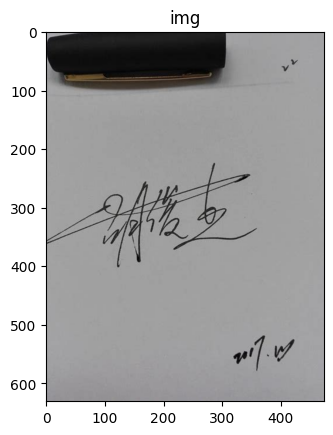

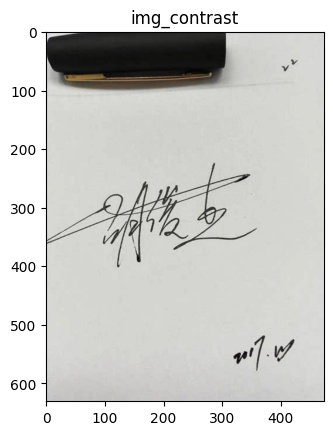

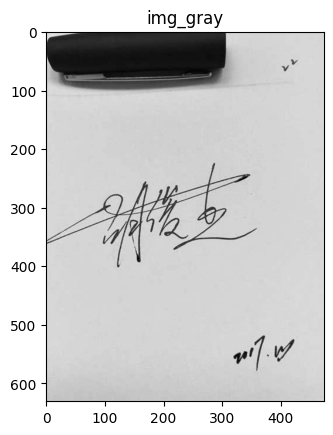

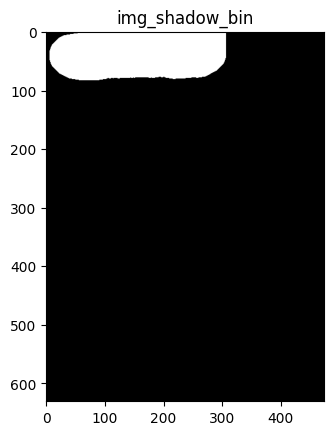

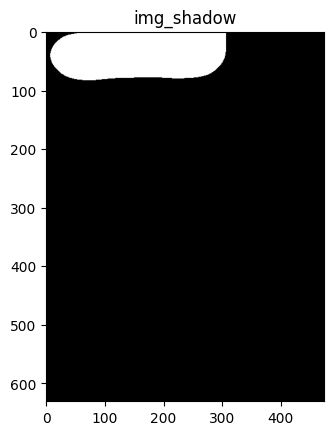

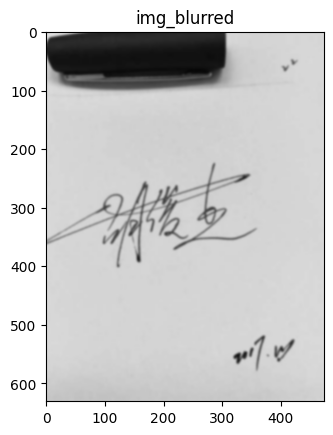

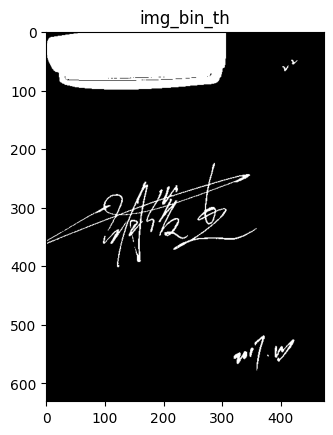

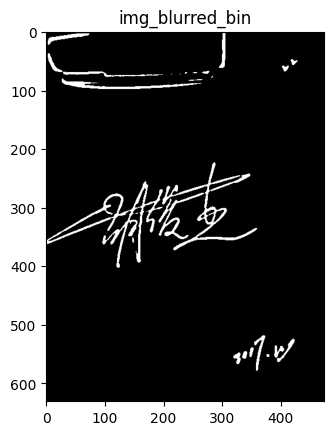

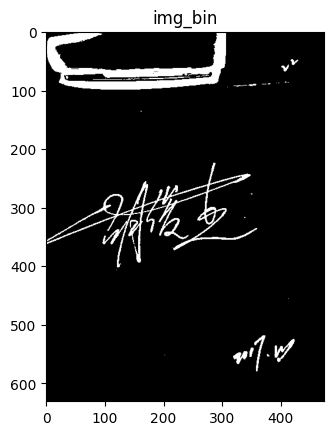

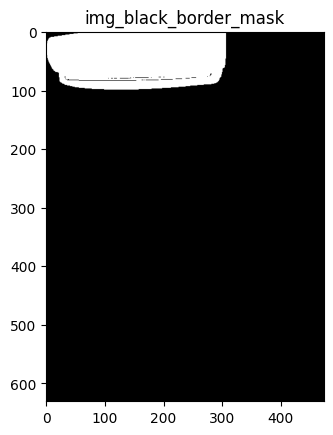

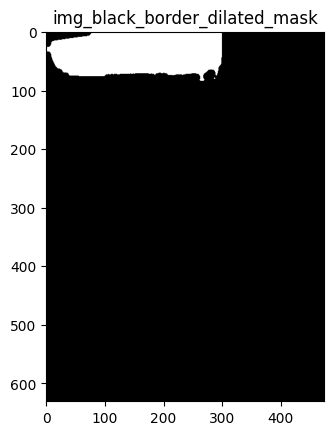

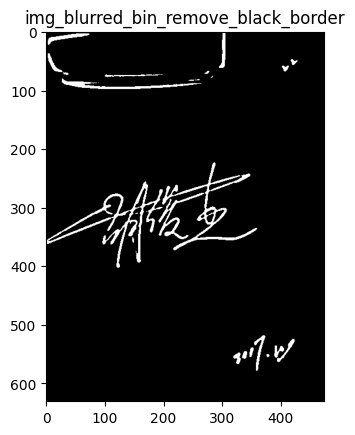

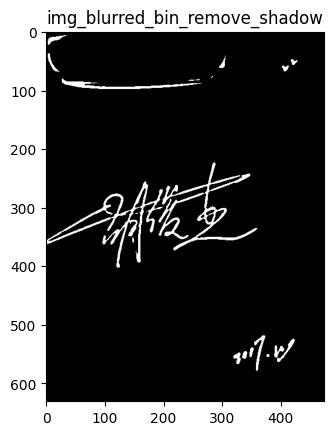

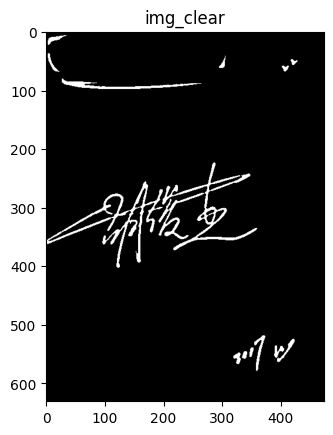

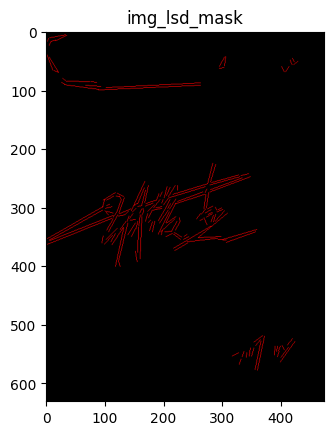

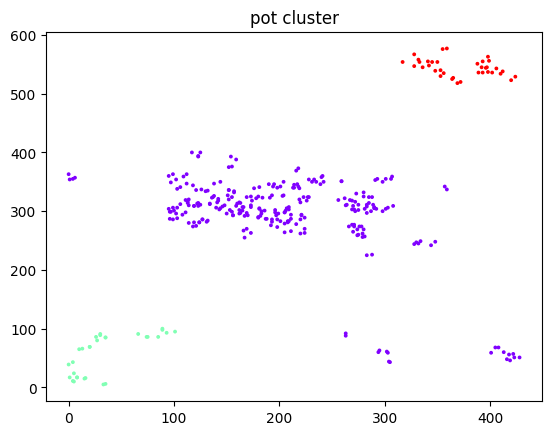

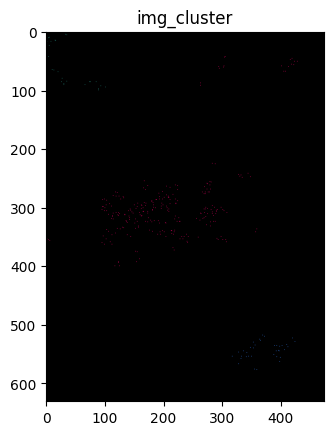

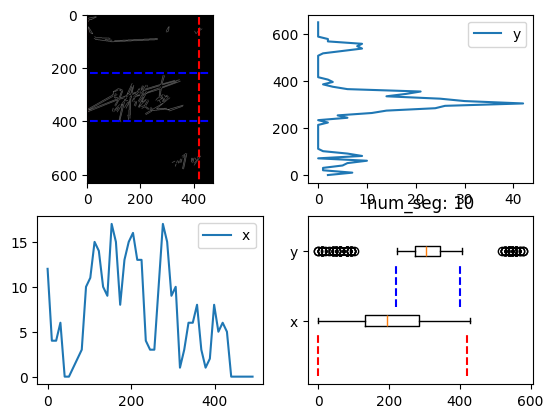

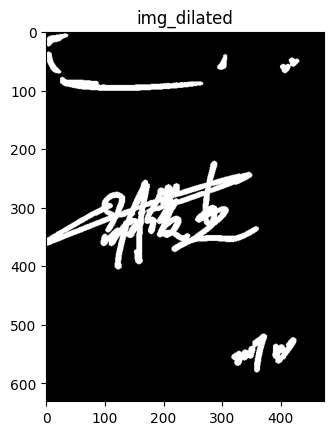

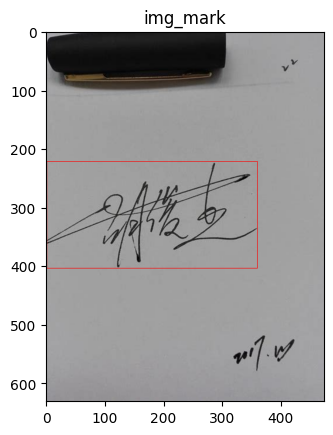

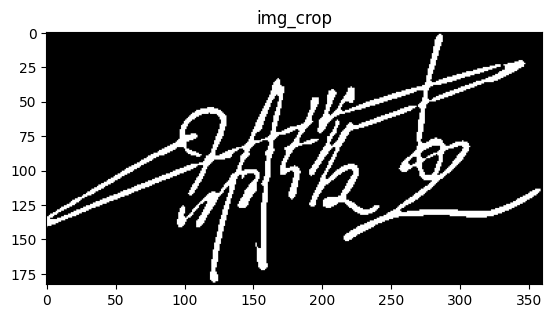

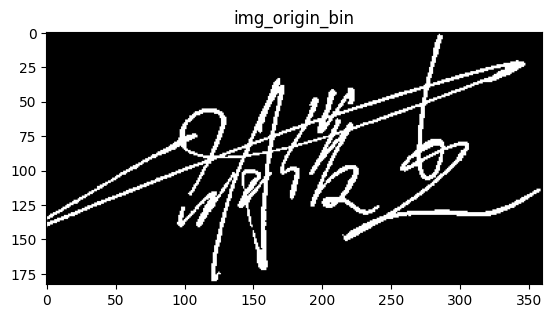

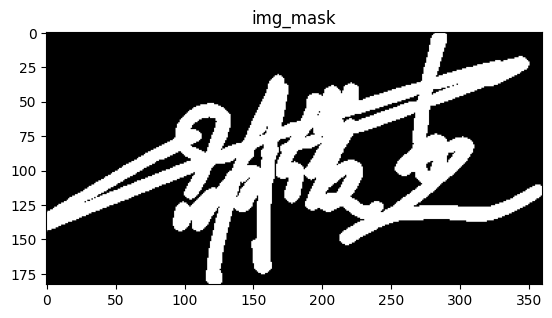

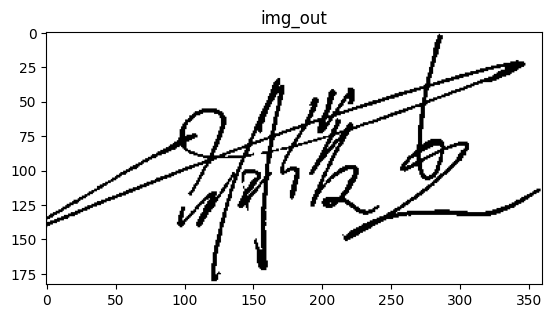

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.17s/it]

else: https://th.bing.com/th/id/OIP.F_iDIzlecoAtZvWyndFtvgHaJ3
[]


In [4]:
from tqdm import tqdm

urls_simple = [
    "https://img.zcool.cn/community/01a62d56d1308132f875520fe0d28c.jpg",
    "https://gss0.baidu.com/94o3dSag_xI4khGko9WTAnF6hhy/zhidao/pic/item/64380cd7912397ddd93d5f575882b2b7d0a28719.jpg",
    "https://gss0.baidu.com/-vo3dSag_xI4khGko9WTAnF6hhy/zhidao/wh%3D450%2C600/sign=04e1f2406959252da342150001ab2f0d/3812b31bb051f8195b001310d3b44aed2e73e747.jpg",
    "https://img2.baidu.com/it/u=658979757,3406562194&fm=253&fmt=auto&app=138&f=JPEG",
    "https://img1.baidu.com/it/u=842283601,2994687281&fm=253&fmt=auto&app=138&f=JPEG", # lose dot
    "https://gss0.baidu.com/9fo3dSag_xI4khGko9WTAnF6hhy/zhidao/pic/item/4afbfbedab64034fdaaabca2a7c379310a551d2a.jpg", # contrast
    "https://gss0.baidu.com/-Po3dSag_xI4khGko9WTAnF6hhy/zhidao/wh=450,600/sign=149c1205942f07085f502204dc1494af/d53f8794a4c27d1e41513b8e11d5ad6eddc43800.jpg",
    "https://img2.baidu.com/it/u=1905701209,2370765614&fm=253&fmt=auto&app=138&f=JPEG", 
    "https://ss1.baidu.com/-4o3dSag_xI4khGko9WTAnF6hhy/zhidao/wh%3D450%2C600/sign=c02333c611d8bc3ec65d0eceb7bb8a28/b3119313b07eca80c99abf1b992397dda04483ab.jpg",
    "https://so1.360tres.com/t015c85f1c7bc458114.jpg", # white bordor on left and right
    "https://i.ebayimg.com/images/g/hXgAAOSw5XpbyMfg/s-l500.jpg",
    "https://pic4.zhimg.com/v2-945edaceafff189ccc819508a894867f_r.jpg",
    "https://gss0.baidu.com/9vo3dSag_xI4khGko9WTAnF6hhy/zhidao/pic/item/738b4710b912c8fc3a7f065af7039245d788219d.jpg",
    "https://th.bing.com/th/id/OIP.7-9HhuEo-kiwpjbAiiw76AHaJ3",
    "https://bkimg.cdn.bcebos.com/pic/810a19d8bc3eb135df9d390ca11ea8d3fd1f442b",
    "https://th.bing.com/th/id/OIP.Yab60CXlFPYSMLLvjhavJAHaHa?rs=1&pid=ImgDetMain",
    "https://storage.ning.com/topology/rest/1.0/file/get/9333466484?profile=RESIZE_710x", # shadow
    "https://th.bing.com/th/id/OIP.KOi_H6MrqbJMMpWc6KZ_bwHaHW",
    "https://www.ccguitar.cn/pu/2019/12/14/153441_39347.jpg",
    "https://th.bing.com/th/id/OIP.PcMR7RPzLNowiCoQPvBOTQHaK0",
    "https://th.bing.com/th/id/R.a074f88c2347b40e4a0da80344f123a1?rik=xyu4GKemw9SMBA&riu=http%3a%2f%2fn.sinaimg.cn%2fsinacn16%2f643%2fw640h803%2f20181010%2f7fe9-hkrzyan6081441.jpg&ehk=40sHPHdQHGtCInrxiESlgkqVyFH8WCty6c5Ak3JTSGs%3d&risl=&pid=ImgRaw&r=0",
    "https://th.bing.com/th/id/R.7f0a1e082b4154f84c5f1fffcb5fc841?rik=qijZ9DsY7kW0ng&riu=http%3a%2f%2fi2.kknews.cc%2f3Gi3iO9P3ijmLXzY0B9PF7NbZfchhPpDOcVmSWg%2f0.jpg&ehk=nxwHrAV9md05q3Qi9FPcJPnsam6Hy1pzSq0J3OnZdFI%3d&risl=&pid=ImgRaw&r=0",
]

urls_medium = [
    "https://img2.baidu.com/it/u=2576319358,1293281589&fm=253&fmt=auto&app=138&f=JPEG", # edge #TODO
    "https://img2.baidu.com/it/u=2027884974,2375522895&fm=253&fmt=auto&app=138&f=JPEG", # contrast, line #TODO
    "https://img1.baidu.com/it/u=261235808,3950404233&fm=253&fmt=auto&app=138&f=JPEG", # contrast, miss #TODO
    "https://img1.baidu.com/it/u=150432405,503740067&fm=253&fmt=auto&app=138&f=JPEG",
    "https://img2.baidu.com/it/u=2727850076,1642987732&fm=253&fmt=auto&app=138&f=JPEG",
    "https://ss2.baidu.com/-vo3dSag_xI4khGko9WTAnF6hhy/zhidao/pic/item/0df3d7ca7bcb0a468fe700d16363f6246a60af15.jpg", # miss, top on bordor # TODO
    "https://img1.baidu.com/it/u=1817958958,1071794667&fm=253&fmt=auto&app=138&f=JPEG", # lines
    "https://th.bing.com/th/id/OIP.x3bT0ClG0sgp9H9fAeELqAAAAA?w=459&h=344&rs=1&pid=ImgDetMain", # contast, folds
    "https://pictures.abebooks.com/inventory/30664580933_2.jpg",
    "https://th.bing.com/th/id/R.f193af45d6fa9fe3e19afd2db545d69a?rik=tcikxnYjxdDfmw&riu=http%3a%2f%2fimg1.k68.cn%2fk68over2008-02%2f75482%2fk68_cn_20084295457_02.jpg&ehk=hbWEw0b9aylqEp34PFZflS9bPS6q6LtoZz9A00e0jXE%3d&risl=&pid=ImgRaw&r=0",
    "https://th.bing.com/th/id/R.b8d009148f773b205a1fa4173a10d515?rik=gd2N%2fgDy4UrSCQ&riu=http%3a%2f%2fwww.shuyueliang.com%2fUpload%2fArticles%2f3%2f0%2f30%2f30696_20190528012529103.jpg&ehk=AWWSOuO6Hn26eemdJlEKVtpn7Tohe8YL1IP1JX8gRzo%3d&risl=&pid=ImgRaw&r=0",
    "https://gss0.baidu.com/94o3dSag_xI4khGko9WTAnF6hhy/zhidao/wh%3D600%2C800/sign=02c9fdaab87eca80125031e1a113bbe5/7af40ad162d9f2d3e7f47f66a1ec8a136227cc56.jpg",
    "https://th.bing.com/th/id/OIP.e0a3u1NCZFedQEQLB_GkQQHaJ4", # shadow
    "https://th.bing.com/th/id/OIP.lqO1no6eM8ngxCkGVMlBkAHaHa",
    "https://th.bing.com/th/id/OIP.DikWwmFk97CG0NUqiDykHAHaIS", # border
]

urls_complex = [
    "https://img1.baidu.com/it/u=2653203503,3985836054&fm=253&fmt=auto&app=138&f=JPEG", # mix sign and print font
    "https://ss1.baidu.com/9vo3dSag_xI4khGko9WTAnF6hhy/zhidao/wh%3D600%2C800/sign=aacf440d3b12b31bc739c52fb6281a42/cc11728b4710b91211be2eb4c1fdfc0392452279.jpg", # lines
    "https://gss0.baidu.com/94o3dSag_xI4khGko9WTAnF6hhy/zhidao/pic/item/fcfaaf51f3deb48f343043a7f31f3a292df5786a.jpg", # lines
    "https://img0.baidu.com/it/u=305817378,398406953&fm=253&fmt=auto&app=120&f=JPEG?w=800&h=500", # finger figure on right bottom
    "https://th.bing.com/th/id/OIP.v49DNq9jB6QgqzxhmQ6w_wHaFj", # line
    "https://i.pinimg.com/originals/3b/e5/33/3be533118800e62745874ed2ffe30ac2.jpg", # line, print font
    "https://th.bing.com/th/id/OIP.G6eAFcVRq_d52YzZkFFJuQHaJ4", # background, folds
    "https://th.bing.com/th/id/OIP.F_iDIzlecoAtZvWyndFtvgHaJ3",
    "https://th.bing.com/th/id/R.715f4ba472861c2c9841e2b34a202d77?rik=ECxSeOpyPQ7Deg&riu=http%3a%2f%2fi1.kknews.cc%2fCsozFti5ffD0PpmDp6Q7g4-pg421ub1CFECNrSw%2f0.jpg&ehk=GmOIwoR0xNS5T%2fzCMwa%2f7Vl1B7juwTX9PCBcJvL8wVA%3d&risl=&pid=ImgRaw&r=0", # background, print text
    "https://th.bing.com/th/id/OIP.go1PRxuuyWLdw6ELpdNKOgHaEc", # on paper background
    "https://syomeidesign.tokyo/wp-content/uploads/2021/10/image-8.png", # on paper background
    "https://th.bing.com/th/id/OIP.Iy-wmFAMSDKcKS2M29q9EwHaFj", # shadow, background
    "https://th.bing.com/th/id/OIP.1xRqfjHXrVNNXTj47B22agHaHa", # folds, lines
]

urls = [
] + urls_simple + urls_medium + urls_complex

def read_img_from_url(url: str) -> cv.Mat:
    import urllib
    resp = urllib.request.urlopen(url)
    img_url = np.asarray(bytearray(resp.read()), dtype="uint8")
    img_url = cv.imdecode(img_url, cv.IMREAD_COLOR)
    return img_url

img = None
out_dir = "out"
for url in tqdm(urls[:]):
    # print(f"load url: {url}")
    img = read_img_from_url(url)
    # img_rotated = rotate_retain_total(img, 15)
    img = resize_img(img, (720, 720))
    img_dict = None
    run(img, is_show=True) # show
    # img_dict = run(img, is_show=False, path=os.path.join(out_dir, f'{os.path.basename(url)[5:]}')) # save

    if img_dict is not None:
        for i, (k, v) in enumerate(img_dict.items()):
            cv.imwrite(os.path.join(out_dir, f'{os.path.basename(url)[5:]}-{i}-{k}.jpg'), v)
            pass
    else:
        print(f"else: {url}")
print(no_sign)

# Widgets

## Canny

In [ ]:
import ipywidgets as widgets
# %matplotlib notebook
%matplotlib widget

output = widgets.Output()
threshold1 = widgets.IntSlider(description="threshold1", min=0, max=255, value=20)
threshold2 = widgets.IntSlider(description="threshold2", min=0, max=255, value=100)
apertureSize = widgets.IntSlider(description="apertureSize", min=3, max=7, value=3) # only 3 or 7

fig = plt.figure()
img_show = plt.imshow(img)
def on_change(threshold1, threshold2, apertureSize):
    with output:
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img_edges = cv.Canny(img_gray, threshold1, threshold2, apertureSize=apertureSize)
        img_out = cv.cvtColor(img_edges, cv.COLOR_BGR2RGB)
        img_show.set_data(img_out)
        fig.canvas.draw_idle()

w_candy = widgets.interactive(on_change, threshold1=threshold1, threshold2=threshold2, apertureSize=apertureSize)
display(w_candy, output)

## Hough

In [ ]:
import ipywidgets as widgets
# %matplotlib notebook
%matplotlib widget

output = widgets.Output()
rho = widgets.FloatSlider(description="rho", min=0.1, max=10, step=0.1, value=1)
theta = widgets.IntSlider(description="theta", min=1, max=180, value=180)
threshold = widgets.IntSlider(description="threshold", min=1, max=500, value=100)
minLineLength = widgets.IntSlider(description="minLineLength", min=1, max=1000, value=10)
maxLineGap = widgets.IntSlider(description="maxLineGap", min=0, max=100, value=100)

fig = plt.figure()
img_show = plt.imshow(img)
def on_change(rho, theta, threshold, minLineLength, maxLineGap):
    with output:
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img_edges = cv.Canny(img_gray, 20, 50, apertureSize=3)
        img_copy = img.copy()
        lines = cv.HoughLinesP(img_edges, rho=rho, theta=np.pi/theta, threshold=threshold, minLineLength=minLineLength, maxLineGap=maxLineGap)
        if lines is None:
            print(f"theta: {theta} | lines: {lines}")
            return
        for i in range(len(lines)):
            cv.line(img_copy, (lines[i, 0, 0], lines[i, 0, 1]), (lines[i, 0, 2], lines[i, 0, 3]), (0, 255, 0), 2)
        img_out = cv.cvtColor(img_copy, cv.COLOR_BGR2RGB)
        img_show.set_data(img_out)
        fig.canvas.draw_idle()

w = widgets.interactive(on_change, rho=rho, theta=theta, threshold=threshold, minLineLength=minLineLength, maxLineGap=maxLineGap)
display(w, output)

## threshold

interactive(children=(IntSlider(value=127, description='threshold', max=255), Output()), _dom_classes=('widget…

Output()

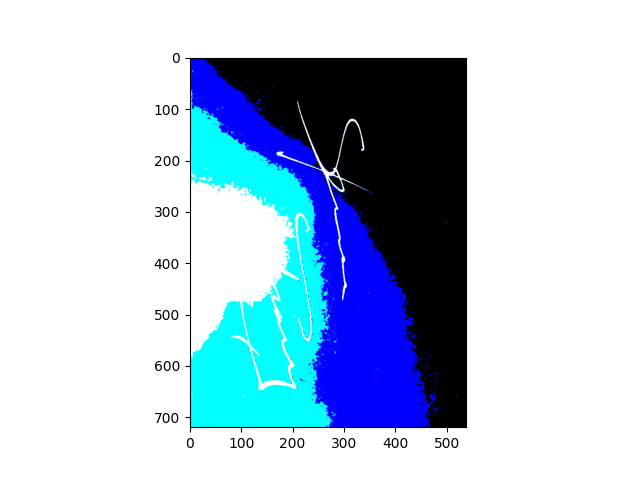

In [74]:
import ipywidgets as widgets
# %matplotlib notebook
%matplotlib widget

output = widgets.Output()
threshold = widgets.IntSlider(description="threshold", min=0, max=255, value=127)

fig = plt.figure()
img_show = plt.imshow(img)
def on_change(threshold):
    with output:
        ret, img_out = cv.threshold(img, threshold, 255, cv.THRESH_BINARY_INV)
        img_out = cv.cvtColor(img_out, cv.COLOR_BGR2RGB)
        img_show.set_data(img_out)
        fig.canvas.draw_idle()

w_hls = widgets.interactive(on_change, threshold = threshold)
display(w_hls, output)

## adaptiveThreshold

interactive(children=(IntSlider(value=21, description='block_size', max=101, min=3, step=2), IntSlider(value=1…

Output()

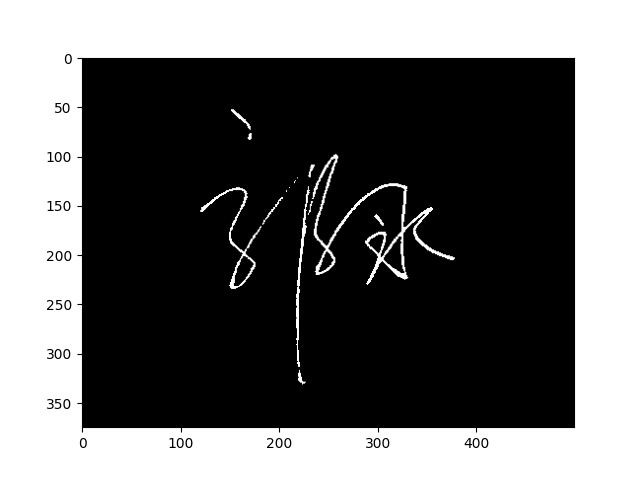

In [12]:
import ipywidgets as widgets
# %matplotlib notebook
%matplotlib widget

output = widgets.Output()
block_size = widgets.IntSlider(description="block_size", min=3, max=101, step=2, value=21)
C = widgets.IntSlider(description="C", min=0, max=20, value=10)

fig = plt.figure()
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_show = plt.imshow(img_gray)
def on_change(block_size:int=21, C:float=10):
    with output:
        img_out = cv.adaptiveThreshold(img_gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, blockSize=block_size, C=C)
        img_out = cv.cvtColor(img_out, cv.COLOR_BGR2RGB)
        img_show.set_data(img_out)
        fig.canvas.draw_idle()

w_hls = widgets.interactive(on_change, block_size = block_size, C = C)
display(w_hls, output)

## inRange

interactive(children=(IntSlider(value=50, description='lowerb', max=255, step=2), IntSlider(value=127, descrip…

Output()

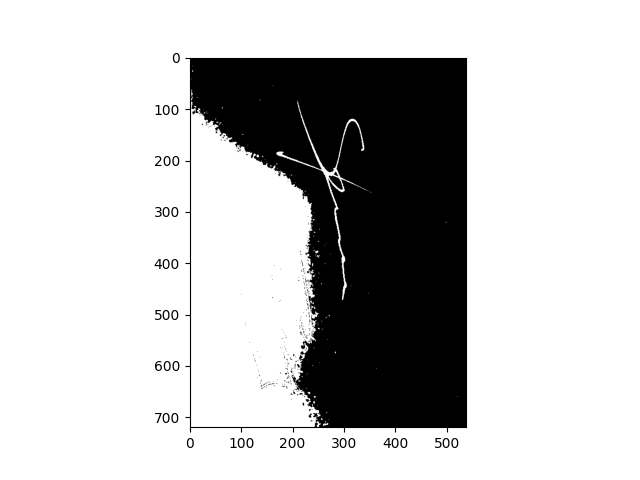

In [73]:
import ipywidgets as widgets
# %matplotlib notebook
%matplotlib widget

output = widgets.Output()
lowerb = widgets.IntSlider(description="lowerb", min=0, max=255, step=2, value=50)
upperb = widgets.IntSlider(description="upperb", min=0, max=255, step=2, value=127)

fig = plt.figure()
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_show = plt.imshow(img_gray)
def on_change(lowerb:int=50, upperb:int=100):
    with output:
        img_out = cv.inRange(img_gray, lowerb=lowerb, upperb=upperb)
        img_out = cv.cvtColor(img_out, cv.COLOR_BGR2RGB)
        img_show.set_data(img_out)
        fig.canvas.draw_idle()

w_hls = widgets.interactive(on_change, lowerb = lowerb, upperb = upperb)
display(w_hls, output)

## HSL

interactive(children=(IntSlider(value=0, description='min_H', max=255), IntSlider(value=255, description='max_…

Output()

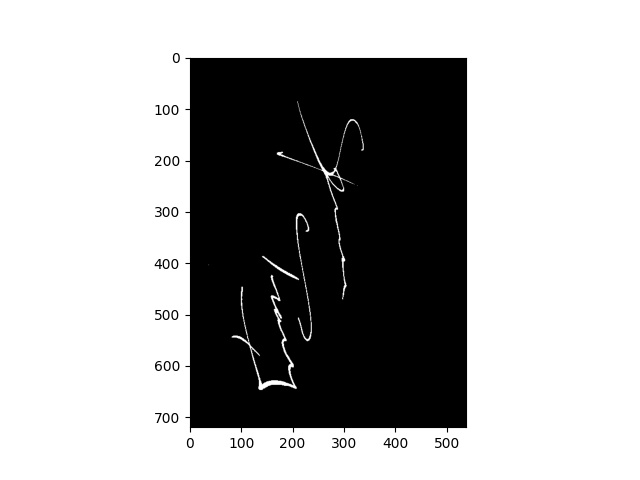

In [75]:
import ipywidgets as widgets
# %matplotlib notebook
%matplotlib widget

output = widgets.Output()
min_H = widgets.IntSlider(description="min_H", min=0, max=255, value=0)
min_L = widgets.IntSlider(description="min_L", min=0, max=255, value=0)
min_S = widgets.IntSlider(description="min_S", min=0, max=255, value=0)
max_H = widgets.IntSlider(description="max_H", min=0, max=255, value=255)
max_L = widgets.IntSlider(description="max_L", min=0, max=255, value=100)
max_S = widgets.IntSlider(description="max_S", min=0, max=255, value=255)

fig = plt.figure()
img_show = plt.imshow(img)
def on_change(min_H, max_H, min_L, max_L, min_S, max_S):
    with output:
        img_bin = cv.cvtColor(img, cv.COLOR_BGR2HLS)
        lower = np.uint8([min_H, min_L, min_S])
        upper = np.uint8([max_H, max_L, max_S])
        mask = cv.inRange(img_bin, lower, upper)
        img_out = mask
        img_out = cv.cvtColor(img_out, cv.COLOR_BGR2RGB)
        img_show.set_data(img_out)
        fig.canvas.draw_idle()

w_hls = widgets.interactive(on_change, min_H=min_H, max_H=max_H, min_L=min_L, max_L=max_L, min_S=min_S, max_S=max_S)
display(w_hls, output)

## LSD

In [ ]:
import ipywidgets as widgets
# %matplotlib notebook
%matplotlib widget

output = widgets.Output()
ang_th = widgets.IntSlider(description="ang_th", min=1, max=179, value=160)
scale = widgets.FloatSlider(description="scale", min=0, max=1., step=0.1, value=0.6)
quant = widgets.IntSlider(description="quant", min=0, max=10, value=2)

fig = plt.figure()
img_show = plt.imshow(img)
def on_change(ang_th, scale, quant):
    with output:
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        lsd = cv.createLineSegmentDetector(ang_th=ang_th, scale=scale, quant=quant)
        lines = lsd.detect(img_gray)[0]   # Position 0 of the returned tuple are the detected lines
        if lines is None:
            print(f"{ang_th} is None")
            return
        img_out = lsd.drawSegments(img.copy(), lines)
        img_out = cv.cvtColor(img_out, cv.COLOR_BGR2RGB)
        img_show.set_data(img_out)
        fig.canvas.draw_idle()

w = widgets.interactive(on_change, ang_th=ang_th, scale=scale, quant=quant)
display(w, output)

## color threshold contours

In [ ]:
import ipywidgets as widgets
# %matplotlib notebook
%matplotlib widget

output = widgets.Output()
min_val = widgets.IntSlider(description="min_val", min=0, max=255, value=100)
max_val = widgets.IntSlider(description="max_val", min=0, max=255, value=200)

fig = plt.figure()
img_show = plt.imshow(img)
def on_change(min_val, max_val):
    with output:
        img_out = img.copy()
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        ret, thresh = cv.threshold(img_gray, min_val, max_val, cv.THRESH_BINARY)
        contours, hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        cv.drawContours(img_out, contours, -1, (30, 255, 50), thickness=2)
        img_out = cv.cvtColor(img_out, cv.COLOR_BGR2RGB)
        img_show.set_data(img_out)
        fig.canvas.draw_idle()

w = widgets.interactive(on_change, min_val=min_val, max_val=max_val)
display(w, output)